## **Malaria Parasite Detection**
### **Executive Summary**
Despite advancements in combating Malaria, the disease still remains an endemic in some parts of the world. Africa, due to its tropical nature is more prone to the disease. Much as there are methods which have been developed to prevent and control the disease, these methods heavily rely on manual examinations of blood smears under a microscope, these methods are not only time consuming but require skilled personell.

Under this project we will explore a deep learning algorithm known as a convolutional neural network(CNN) that employs different mechanisms, such as local receptive fields, shared weights, and clustering layers, to leverage information. Its purpose extends to predictive targets that can effectively aid in detecting and classifying malaria parasites

### **Objective**

To classify whether a blood smear cell image is uninfected or parasitized

### **Evaluation Metrics**

1. Area Under the Curve (AUC)

2. Recall 

In [27]:
# import libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten,BatchNormalization, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
# load data 
df, df_info = tfds.load("malaria", 
                        split=['train'], 
                        with_info=True, 
                        shuffle_files=True, 
                        as_supervised=True)

#### Data Understanding

In [3]:
# display dataset metadata
print(f"Malaria Dataset Metadata:\n{df_info}")

Malaria Dataset Metadata:
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Atieno\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria 

*Based on the information above :*
1. The Malaria dataset contains 27,558 cell images
2. The dataset is balanced with equal number of both parasitized and uninfected blood smear images
3. There 2 features: image and label
4. The label feature has two classes

#### Preprocessing
Preprocessing allows us to prepare the Malaria dataset such that it can be fed into the neural network, preprocessing also allows us to evaluate the model's performance through splitting the dataset

In [4]:
def split_data(df, train_ratio, val_ratio, test_ratio):

    """
    The Malaria dataset will be split into testing, validation and training set,
    the splitting ratio will be 60% training, 20% testing, 20% validation
    """
    
    df_size = len(df)

    train_df = df.take(int(train_ratio * df_size))

    validation_df = df.skip(int(train_ratio * df_size))
    validation_df = df.take(int(val_ratio * df_size))

    test_df = df.skip(int(train_ratio * df_size))
    test_df = df.skip(int(val_ratio * df_size))
    test_df = df.take(int(test_ratio * df_size))

    return train_df, validation_df, test_df

train_df, validation_df, test_df = split_data(df[0], 0.6, 0.2, 0.2)

In [5]:
# check image size of sample images
for image in train_df.take(3):
    print(image)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

*if you look at the tensor shape, you will notice that each sample image is of a different size, all the image cells need to have the same dimensions before being fed into the network*

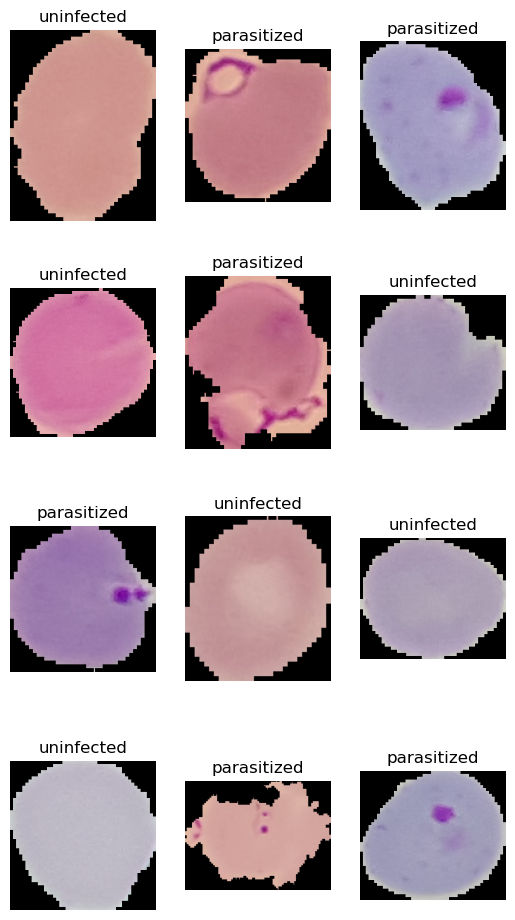

In [6]:
# preview a sample of the cell images
for i , (image,label) in enumerate(train_df.take(12)):
    ax = plt.subplot(4,3 ,i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(df_info.features['label'].int2str(label))
    plt.subplots_adjust(top=2)

In [7]:
# set image size to 
# 224*224 pixels
IMG_SIZE = 224 

def image_preprocessing(image, label):

    """
    resize the cell images such that
    they all have the same dimensions
    then normalize the image data
    """
    
    return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, label

# map image preprocessing to every element in the training set 
train_df = train_df.map(image_preprocessing)

# map image preprocessing to every element in the validation set 
validation_df = validation_df.map(image_preprocessing)

# map image preprocessing to every element in the test set 
test_df = test_df.map(image_preprocessing)

# introduce randomness
# create batches of 32 samples
train_df = train_df.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
validation_df = validation_df.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_df = test_df.batch(1)

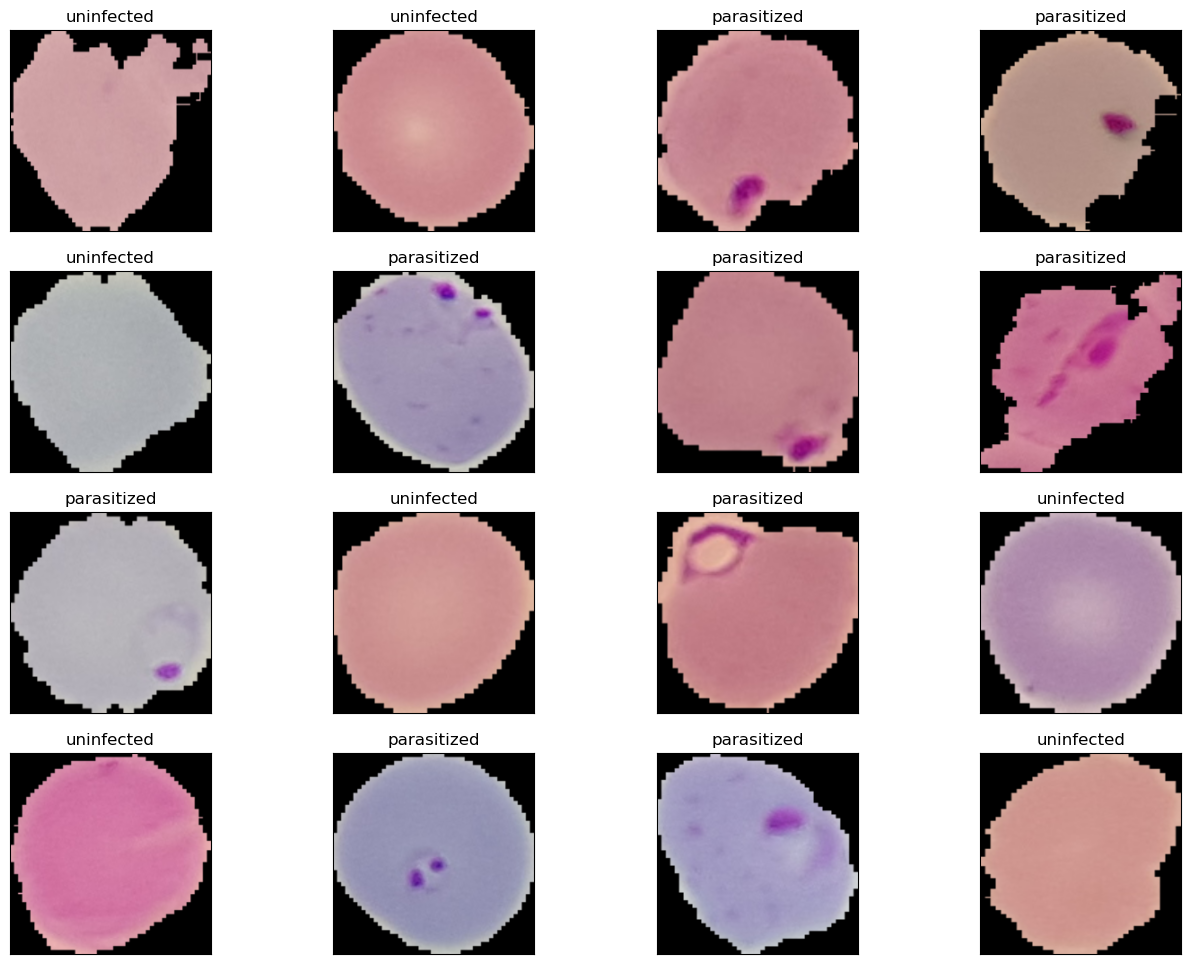

In [31]:
# preview images after preprocessing
mage, label = next(iter(train_df))
df_names = df_info.features["label"].names

plt.figure(figsize= (16,12))

for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(image[i])
    if label[i]:
        plt.title(df_names[1])
    else:
        plt.title(df_names[0])

#### Model Building
##### Base Model

In [8]:
# build model architecture

base_model = Sequential([
    InputLayer(shape = (IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters=6, kernel_size=5, strides=1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# compile model
base_model.compile(optimizer=Adam(learning_rate=0.01), loss = BinaryCrossentropy(), metrics = [tf.metrics.AUC(),'acc', tf.metrics.Recall(), tf.metrics.Precision()])

# obtain model results
base_history = base_model.fit(train_df, validation_data = validation_df, epochs = 30, verbose=1)

Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 402s 577ms/step - acc: 0.6663 - auc: 0.7251 - loss: 0.6104 - precision: 0.6709 - recall: 0.6633 - val_acc: 0.8348 - val_auc: 0.9182 - val_loss: 0.3950 - val_precision: 0.7802 - val_recall: 0.9481
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 374s 542ms/step - acc: 0.8890 - auc: 0.9472 - loss: 0.2792 - precision: 0.8977 - recall: 0.8792 - val_acc: 0.5183 - val_auc: 0.5000 - val_loss: 0.6925 - val_precision: 0.5183 - val_recall: 1.0000
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 355s 516ms/step - acc: 0.5003 - auc: 0.4946 - loss: 0.6934 - precision: 0.4807 - recall: 0.3524 - val_acc: 0.4817 - val_auc: 0.5000 - val_loss: 0.6940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 359s 521ms/step - acc: 0.5002 - auc: 0.4941 - loss: 0.6934 - precision: 0.4807 - recall: 0.3504 - val_acc: 0.4813 - val_auc: 0.5000 - val_loss: 0.6939 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 

#### Model Performance

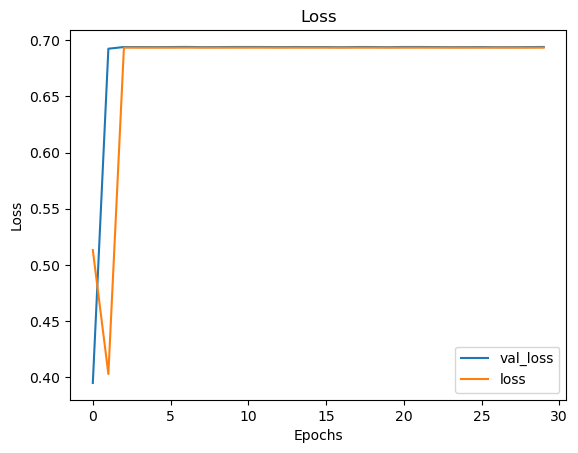

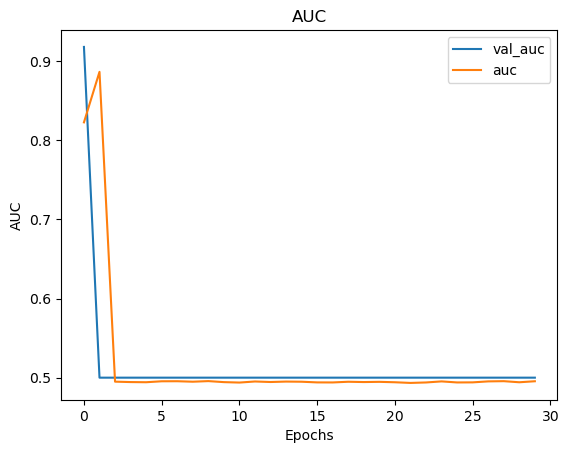

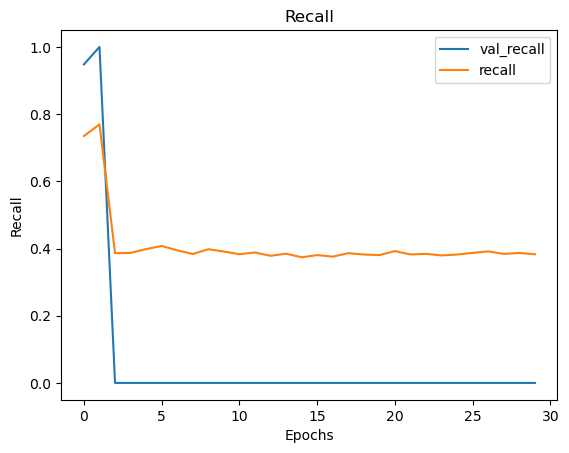

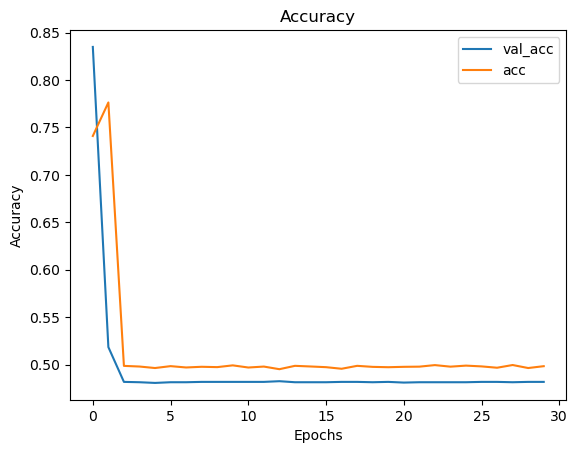

In [15]:
def visualize_base_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_auc'])
    plt.plot(history['auc'])
    plt.legend(['val_auc', 'auc'])
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.show()

    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_base_results(base_history)

##### Second Model

In [12]:
# build model architecture
uno_model = Sequential([
    InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# compile model
uno_model.compile(optimizer=Adam(learning_rate=0.01), loss = BinaryCrossentropy(), metrics = [tf.metrics.AUC(),'acc', tf.metrics.Recall(), tf.metrics.Precision()])

# obtain model results
uno_history = uno_model.fit(train_df, validation_data = validation_df, epochs = 5, verbose=1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 375s 539ms/step - acc: 0.5480 - auc_1: 0.5497 - loss: 4.2964 - precision_1: 0.5881 - recall_1: 0.3653 - val_acc: 0.4802 - val_auc_1: 0.4996 - val_loss: 0.6936 - val_precision_1: 0.2000 - val_recall_1: 6.9979e-04
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 342s 497ms/step - acc: 0.4968 - auc_1: 0.4949 - loss: 0.7076 - precision_1: 0.4740 - recall_1: 0.3471 - val_acc: 0.4813 - val_auc_1: 0.5000 - val_loss: 0.6942 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 384s 557ms/step - acc: 0.4979 - auc_1: 0.4963 - loss: 0.6994 - precision_1: 0.4766 - recall_1: 0.3491 - val_acc: 0.4817 - val_auc_1: 0.5000 - val_loss: 0.6939 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 335s 486ms/step - acc: 0.5001 - auc_1: 0.4942 - loss: 0.6934 - precision_1: 0.4805 - recall_1: 0.3582 - val_acc: 0.4813 - val_auc_1: 0.5000 - val_loss: 0.6940 - val_precision_1: 0.0000e+00 - val_recal

#### Model Performance

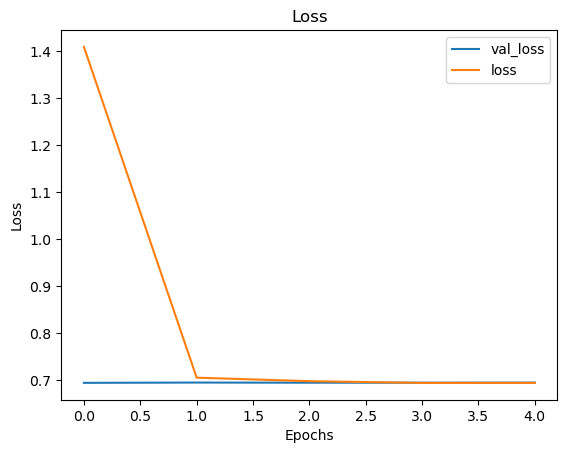

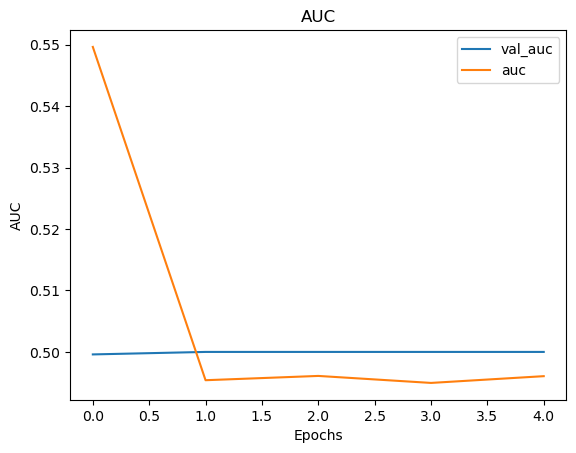

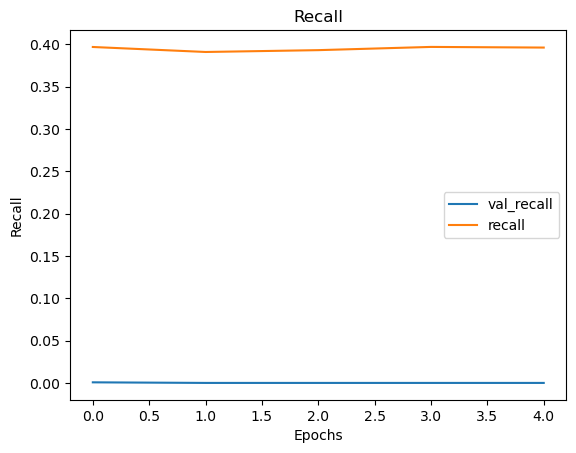

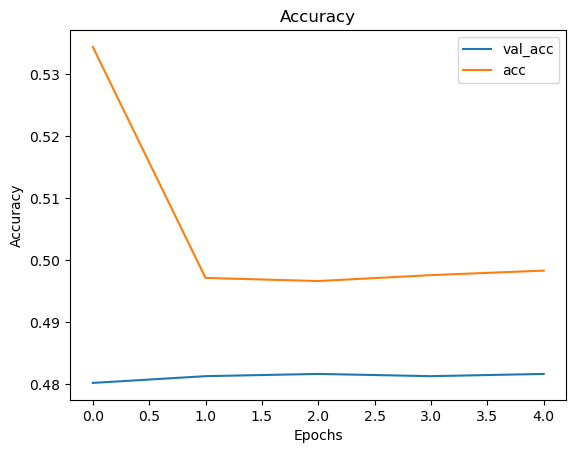

In [16]:
def visualize_uno_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_auc_1'])
    plt.plot(history['auc_1'])
    plt.legend(['val_auc', 'auc'])
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.show()

    plt.figure()
    plt.plot(history['val_recall_1'])
    plt.plot(history['recall_1'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_uno_results(uno_history)

##### Third Model

In [22]:
# build model architecture

multi_model = Sequential([
    InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),

    Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same'),
    Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same'),
    MaxPool2D(),

    Dropout(0.2),

    Flatten(),
    Dense(34, activation = 'relu'),
    Dense(1, activation = 'sigmoid')

])

# compile model
multi_model.compile(optimizer=Adam(learning_rate=0.01), loss = BinaryCrossentropy(), metrics = [tf.metrics.AUC(),'acc', tf.metrics.Recall(), tf.metrics.Precision()])

# obtain model results
multi_history = multi_model.fit(train_df, validation_data = validation_df, epochs = 20, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 480s 651ms/step - acc: 0.5038 - auc_2: 0.4991 - loss: 1.6286 - precision_2: 0.5042 - recall_2: 0.5356 - val_acc: 0.4813 - val_auc_2: 0.5000 - val_loss: 0.6941 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 451s 654ms/step - acc: 0.4990 - auc_2: 0.4939 - loss: 0.6935 - precision_2: 0.4781 - recall_2: 0.3487 - val_acc: 0.4817 - val_auc_2: 0.5000 - val_loss: 0.6939 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 463s 672ms/step - acc: 0.4976 - auc_2: 0.4947 - loss: 0.6934 - precision_2: 0.4757 - recall_2: 0.3423 - val_acc: 0.4817 - val_auc_2: 0.5000 - val_loss: 0.6939 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 563s 818ms/step - acc: 0.4998 - auc_2: 0.4937 - loss: 0.6934 - precision_2: 0.4796 - recall_2: 0.3544 - val_acc: 0.4806 - val_auc_2: 0.5000 - val_loss: 0.6941 - val_precision_2: 0.0000e+00 - v

In [ ]:
#### Model Performace

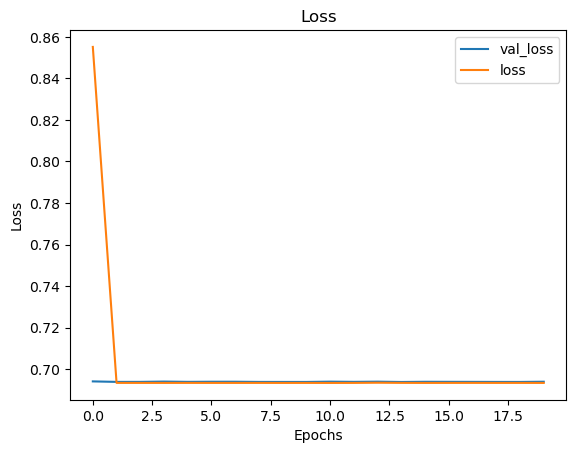

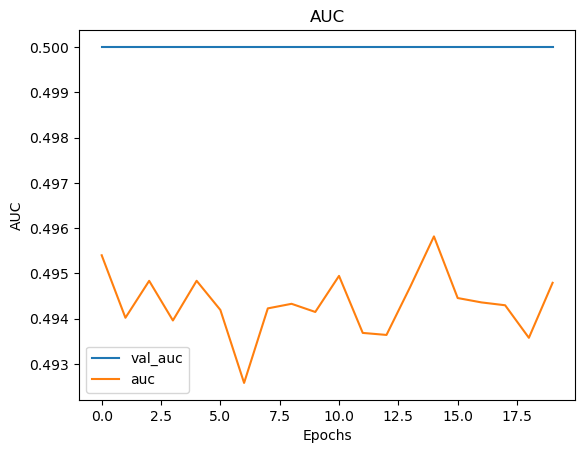

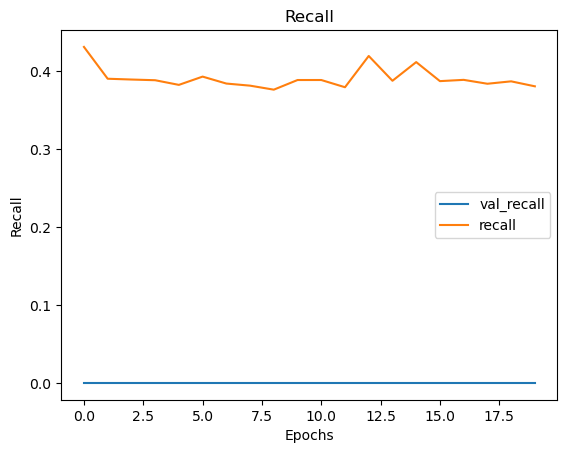

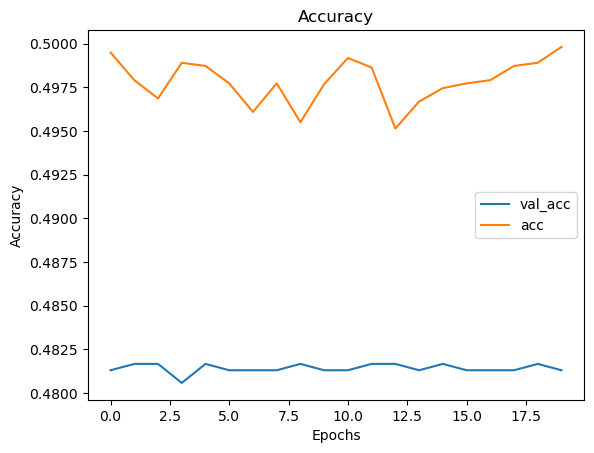

In [24]:
def visualize_multi_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_auc_2'])
    plt.plot(history['auc_2'])
    plt.legend(['val_auc', 'auc'])
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.show()

    plt.figure()
    plt.plot(history['val_recall_2'])
    plt.plot(history['recall_2'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_multi_results(multi_history)

#### Fourth Model

In [28]:
# build model architecture
model = Sequential([
    InputLayer(shape = (IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(filters=6, kernel_size=6, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),

])

# compile model
model.compile(optimizer = Adam(learning_rate=0.01),
                    loss = BinaryCrossentropy(),
                    metrics = [tf.metrics.AUC(),'acc', tf.metrics.Recall(), tf.metrics.Precision()])

# obtain model results                    
model_history = model.fit(train_df, validation_data = validation_df, epochs = 2, verbose=1)

Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 613s 771ms/step - acc: 0.6827 - auc_4: 0.7489 - loss: 0.5788 - precision_4: 0.6831 - recall_4: 0.6940 - val_acc: 0.4824 - val_auc_4: 0.9672 - val_loss: 0.9954 - val_precision_4: 1.0000 - val_recall_4: 0.0014
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 462s 670ms/step - acc: 0.9156 - auc_4: 0.9608 - loss: 0.2385 - precision_4: 0.9071 - recall_4: 0.9279 - val_acc: 0.9292 - val_auc_4: 0.9733 - val_loss: 0.2785 - val_precision_4: 0.9484 - val_recall_4: 0.9132


#### Model Performance

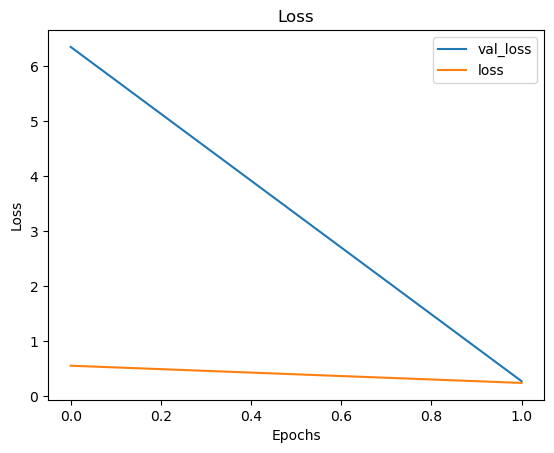

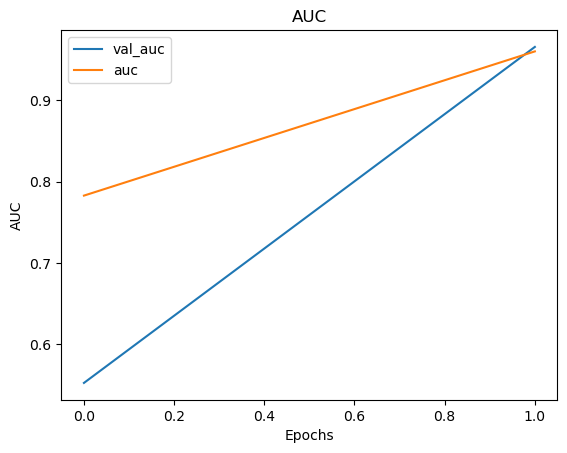

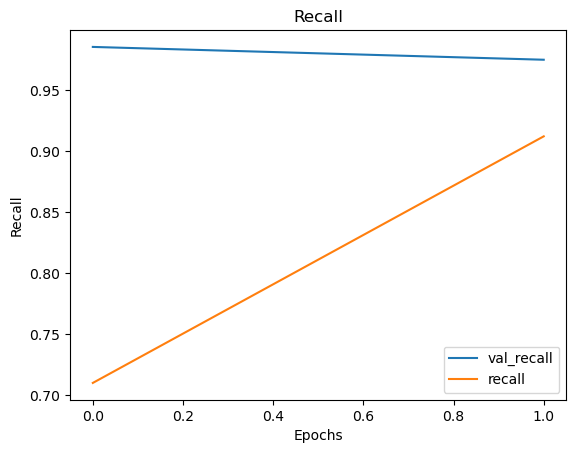

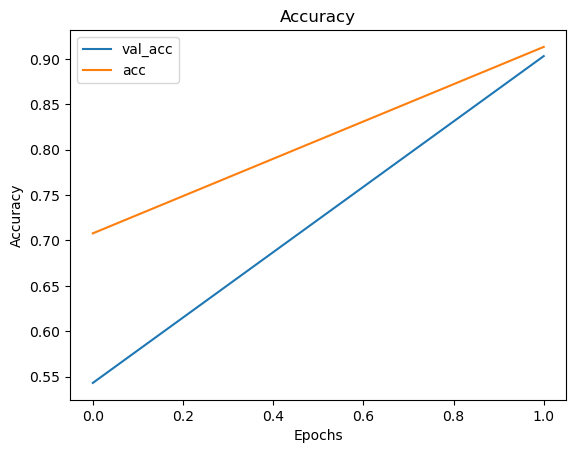

In [26]:
def visualize_model_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_auc_3'])
    plt.plot(history['auc_3'])
    plt.legend(['val_auc', 'auc'])
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.show()

    plt.figure()
    plt.plot(history['val_recall_3'])
    plt.plot(history['recall_3'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_model_results(model_history)

**Inference**
>> Let's look at two key evaluation metrics for this project, AUC and Recall. AUC tells us the models ability to distingush the two classes (parasitized and uninfected). Recall allows us to ask the question, "Out of all the blood cell images we saw that actually had the parasite, what percentage of them did our model correctly identify as having the malaria parasite? Recall might have many false positives but it would also correctly identify every single parasitized cell image as having the malaria disease!

**Base Model**

>> The first model had an AUC of 0.49 and a Recall of 0.35. The Recall increased slightly when the model started to be trained then dropped drastically after which it remained consistent. The AUC also increased slightly at the beginning of the training, then dropped drastically, after whcih it remained consistent

**Second Model**

>> The second model had an AUC of 0.4946 and a Recall of 0.3728. The Recall remained consistent all through. The training AUC dropped drastically when training started then it remained consistent

**Third Model**

>> The third model had an AUC of 0.4940 and a Recall of 0.3458. The Recall kept on flunctuating all through the training. The training AUC was also flunctuating while the validation AUC remained consistent.

**Fourth Model**

>> The fourth model had an AUC of 0.9608 and a Recall of 0.9279. The training Recall kept on increasing all through the model training, while the validation recall was steady. Both the training and validation AUC increased steadily with model training .


The Fourth Model performed the best. 

#### Evaluation

In [29]:
# evaluate fourth models performance 
# on unseen data
model.evaluate(test_df)

2755/2755 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step - acc: 0.9262 - auc_4: 0.9723 - loss: 0.2800 - precision_4: 0.9480 - recall_4: 0.9039


[0.2785279154777527,
 0.9733158349990845,
 0.9292196035385132,
 0.9132260084152222,
 0.948401153087616]